## **Import the TensorFlow library**

This code contains the training for a CNN in which the model learns to recognize the digits. This is different from the other training script because the model learns the digits from 0 to 6. The Idea is to have the digits 7,8,9 for the OL learning to eb applied on the OpenMV camera.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import csv 
import tempfile

import torchvision.models as models
from torchvision import transforms

Load MNIST dataset and split in training and test

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [3]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]

trainLow_samples  = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples = np.sum(np.where(label_test <  6, 1, 0))

# separate in containers data that is lower nad higer than 6
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i]<6):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1
    else:
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1

print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28)
     Train dataset higher than 6 has shape: (23983, 28, 28)

     Test dataset lower than 6 has shape:  (6031, 28, 28)
     Test dataset higher than 6 has shape: (3969, 28, 28)


1.0


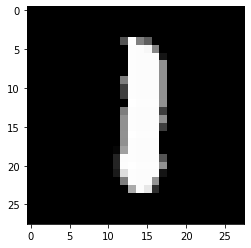

In [4]:
# Randomly check if dataset that I created are filled correctly
num = int(random.uniform(0,trainLow_samples))
plt.imshow(data_low_train[num], cmap="gray") # Import the image
print(label_low_train[num])
plt.show() # Plot the image

## **Pre process the data**

In [5]:
# Image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape     = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape     = (img_rows, img_cols, 1)

Normalize the dataset

In [7]:
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

## **BUILD THE MODEL**

In [8]:
TRAIN_MODEL_1 = False
TRAIN_MODEL_2 = False
TRAIN_MODEL_3 = True

In [9]:
batch_size = 32
epochs     = 40
validation_split = 0.1
optimizer  = "adam"
loss       = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics    = ['accuracy']

In [10]:
if(False):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(6, activation = "softmax"))

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()

In [11]:
if(TRAIN_MODEL_1):
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6,activation='softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print(model.summary())

In [12]:
#if(TRAIN_MODEL_1):
    #tf.keras.utils.plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [13]:
# METHOD 2
# This model is a bit larger and should be much more precise in the feature extraction
if(TRAIN_MODEL_2):
    model2 = Sequential()
    model2.add(Conv2D(32, (3, 3), input_shape = input_shape))
    model2.add(Conv2D(32, (3, 3), activation = "relu"))
    model2.add(MaxPooling2D(pool_size = (2, 2)))
    model2.add(Dropout(0.2))
    model2.add(Flatten())
    model2.add(Dense(128, activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(6, activation = "softmax"))

    model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model2.summary()

In [14]:
if(TRAIN_MODEL_3):

    l = tf.keras.layers # syntax shortcut

    def fire(x, squeeze, expand):
        y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
        y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
        y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
        return tf.keras.layers.concatenate([y1, y3])

    # this is to make it behave similarly to other Keras layers
    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    # usage:
    x = tf.keras.layers.Input(shape=[*input_shape]) # input is 192x192 pixels RGB

    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(6, activation='softmax')(y)

    model3 = tf.keras.Model(x, y)
    model3.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model3.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 24)   792         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 24)   600         conv2d_1[0][0]                   
_______________________________________________________________________________________

## TRAIN THE MODEL

In [15]:
if(TRAIN_MODEL_1):
    model.fit(data_low_train, label_low_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split)

  # Evaluate the model performance
    test_loss, test_acc = model.evaluate(data_low_test, label_low_test)

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

In [16]:
if(TRAIN_MODEL_2):

    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    model2.fit(data_low_train, labels_prova, epochs = epochs, batch_size = batch_size, validation_split = validation_split )

    # Evaluate the model performance
    test_loss, test_acc = model2.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

In [17]:
if(TRAIN_MODEL_3):
    
    labels_modified = keras.utils.to_categorical(label_low_train, 6)
    
    model3.fit(data_low_train, labels_modified, epochs = epochs, batch_size = batch_size, validation_split = validation_split)



Epoch 1/40
1013/1013 [==============================] - 60s 59ms/step - loss: 0.5011 - accuracy: 0.8144 - val_loss: 0.1427 - val_accuracy: 0.9570
Epoch 2/40
1013/1013 [==============================] - 75s 74ms/step - loss: 0.1294 - accuracy: 0.9603 - val_loss: 0.1065 - val_accuracy: 0.9659
Epoch 3/40
1013/1013 [==============================] - 85s 83ms/step - loss: 0.0881 - accuracy: 0.9728 - val_loss: 0.0657 - val_accuracy: 0.9797
Epoch 4/40
1013/1013 [==============================] - 84s 82ms/step - loss: 0.0670 - accuracy: 0.9795 - val_loss: 0.0532 - val_accuracy: 0.9822
Epoch 5/40
1013/1013 [==============================] - 83s 82ms/step - loss: 0.0537 - accuracy: 0.9840 - val_loss: 0.0376 - val_accuracy: 0.9897
Epoch 6/40
1013/1013 [==============================] - 87s 86ms/step - loss: 0.0456 - accuracy: 0.9853 - val_loss: 0.0297 - val_accuracy: 0.9925
Epoch 7/40
1013/1013 [==============================] - 83s 82ms/step - loss: 0.0381 - accuracy: 0.9886 - val_loss: 0.0373 -

NameError: name 'model' is not defined

In [19]:
if(TRAIN_MODEL_3):
    
    labels_modified_test = keras.utils.to_categorical(label_low_test, 6)

# Evaluate the model performance
    test_loss, test_acc = model3.evaluate(data_low_test, labels_modified_test)

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

189/189 [==============================] - 2s 10ms/step - loss: 0.0120 - accuracy: 0.9970

Test accuracy: 0.9970154166221619


## TEST THE MODEL

In [20]:
if(TRAIN_MODEL_1):
    model_test = model
elif(TRAIN_MODEL_2):
    model_test = model2
elif(TRAIN_MODEL_3):
    model_test = model3

In [22]:
# tensorflow evaluation on the test dataset
results = model_test.evaluate(data_low_test, labels_modified_test, batch_size=128)
print("test loss, test acc:", results)

48/48 [==============================] - 2s 33ms/step - loss: 0.0120 - accuracy: 0.9970
test loss, test acc: [0.012002740055322647, 0.9970154166221619]


In [23]:
predictions = model_test.predict(data_low_test)   # Make prediction of entire dataset

In [24]:
num = int(random.uniform(0,data_low_test.shape[0]))
print("Prediction = " , np.argmax(predictions[num]))
print("True label = " , label_low_test[num])

Prediction =  3
True label =  3.0


In [25]:
def plot_image(i, predictions_array, true_label, img):
    class_names = ['0','1','2','3','4','5']

    true_label, img = int(true_label[i]), img[i,:,:]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = (np.squeeze(img))## you have to delete the channel information (if grayscale) to plot the image
    plt.imshow(img, cmap="gray")

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)   


def plot_value_array(i, predictions_array, true_label):
    true_label = int(true_label[i])
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

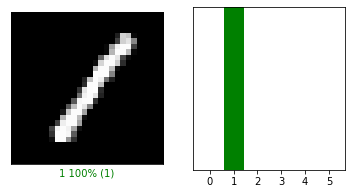

In [26]:
num = int(random.uniform(0, predictions.shape[0]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(num, predictions[num], label_low_test, data_low_test)
plt.subplot(1,2,2)

plot_value_array(num, predictions[num], label_low_test)
plt.show()

## **SAVE ORIGINAL MODEL AND FROZEN MODEL**

In [29]:
def save_summary_model(model, MODEL_PATH, flag):
    new_file = open(MODEL_PATH + 'model_summary.txt', "w")

    new_file.write("PARAMETERS SAVED FROM THE TRAINING")
    if(flag==0):
        new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the ORIGINAL MODEL")
    elif(flag==1):
        new_file.write("\n\n This model has been trained for learning the first 6 digits from the MNIST dataset, this is the FROZEN MODEL")
    new_file.write("\n")
    new_file.write("\n Batch size:       " + str(batch_size))
    new_file.write("\n Epochs:           " + str(epochs))
    new_file.write("\n Metrics:          " + str(metrics))
    new_file.write("\n Optimizer:        " + optimizer)
    new_file.write("\n Loss:             " + "SparseCategoricalCrossentropy \n\n")

    model.summary(print_fn=lambda x: new_file.write(x + '\n'))

In [31]:
ROOT_PATH = os.path.abspath('')
SAVE_MODEL_PATH = ROOT_PATH + "\\Saved_models\\Backup_models\\Last_trained_model"

ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "\\Original_model\\" 

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Save ORIGINAL MODEL as mnist_cnn.h5')
model_test.save(ORIGINAL_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(model_test, ORIGINAL_MODEL_PATH, 0)

Test loss: 0.012002735398709774
Test accuracy: 0.9970154166221619
Save ORIGINAL MODEL as mnist_cnn.h5


Now create the frozen model version for the one just saved. Which means just to cut away the last layer and save the model without the kast kayer. This should be instead saved in a txt/library file.

### SAVE THE FROZEN MODEL

In [32]:
# CREATE AND SAVE THE FROZEN MODEL
frozen_model = keras.models.Sequential(model_test.layers[:-1])
frozen_model.summary()
frozen_model.compile()

FROZEN_MODEL_PATH = SAVE_MODEL_PATH + "\\Frozen_model\\"

print('Save FROZEN MODEL model as mnist_cnn.h5')
frozen_model.save(FROZEN_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(frozen_model, FROZEN_MODEL_PATH, 1)

ValueError: A merge layer should be called on a list of inputs.

Now save also the last layer weights in a txt file, this will later be used in the OpenMV camera for loading the weights that have been already trained. (ll = last layer)

In [ ]:
ll_weights = np.array(model_test.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_test.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_MODEL_PATH + 'll_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

## PRUNING

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

In [ ]:
# Install needed optimization toolkit
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after n epochs.
batch_size = 32
epochs = 5
validation_split = 0.1  # 10% of training set will be used for validation set. 

num_images = data_low_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model_test, **pruning_params)

# `prune_low_magnitude` requires a recompile.

# Select appropriate optimizer
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(data_low_train, label_low_train,
                    batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks)

In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(data_low_test, label_low_test, verbose=0)

print('Original test accuracy: ', test_acc)
print('Pruned test accuracy:   ', model_for_pruning_accuracy)

## CREATE A x3 SMALLER MODEL FROM PRUNING

In [ ]:
# First, create a compressible model for TensorFlow

PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "\\Pruned_model\\"


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.save(PRUNED_MODEL_PATH + 'Pruned_cnn.h5', include_optimizer=False)

In [ ]:
# Then, create a compressible model for TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

with open(PRUNED_MODEL_PATH + 'Pruned_cnn.tflite', 'wb') as f:
    f.write(pruned_tflite_model)

In [ ]:
def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [ ]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(FROZEN_MODEL_PATH + "mnist_cnn.h5")))
print("Size of gzipped pruned Keras model  : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + 'Pruned_cnn.h5')))
print("Size of gzipped pruned TFlite model : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + 'Pruned_cnn.tflite')))

## CREATE A 10x SMALLER MODEL, COMBINE PRUNING WITH QUANTIZATION

https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export) # load the converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.h5')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model             : %.2f bytes" % (get_gzipped_model_size(FROZEN_MODEL_PATH + "mnist_cnn.h5")))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

## SAVE THE FROZEN MODEL VERSION OF THE PRUNED MODEL

In [ ]:
frozen_pruned_model = keras.models.Sequential(model_for_pruning.layers[:-1])
frozen_pruned_model.summary()
frozen_pruned_model.compile()

FROZEN_PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "\\Frozen_Pruned_model\\"

print('Save FROZEN PRUNED MODEL model as Frozen_pruned_cnn.h5')
frozen_model.save(FROZEN_PRUNED_MODEL_PATH + "Frozen_pruned_cnn.h5")
save_summary_model(frozen_pruned_model, FROZEN_PRUNED_MODEL_PATH, 1)

In [ ]:
ll_weights = np.array(model_for_pruning.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_for_pruning.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_PRUNED_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_PRUNED_MODEL_PATH + 'll_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

## DOWNLOAD ENTIIRE MODEL DIRECTORY

In [ ]:
#%cd '/content'
#from google.colab import files
#import shutil
#shutil.make_archive('Colab_models', 'zip', 'Models')
#files.download('Colab_models.zip') 